In [1]:
# Goal: As a simple cross-check use the integrated luminosity for the 6300,6364 complex instead of the complicated fit
import sys, os
import warnings
warnings.filterwarnings("ignore", module="dynesty.sampling")
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as aconst
import astropy.units as u
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import astropy.table as table
from astropy.cosmology import Planck15 as cosmology

try:
    import snelib19odp
except ImportError:
    sys.path.append('../lib')
import snelib19odp.dataloader as dataloader
import snelib19odp.const as const
import snelib19odp.analysis.oxygen as oxygen
import snelib19odp.blackbody as blackbody
import snelib19odp.specds as specds

In [2]:
def flux2luminosity(flux, distance):
    # all in cgs units
    return flux * 4 * np.pi * distance**2
dist_mpc = 64
dist_cm = dist_mpc * 1e6 * u.pc.to(u.cm)

In [3]:
sds = specds.load_dataset('SN2019odp')

In [4]:
#spec = sds['ZTF19abqwtfu_20200821_Keck1_v1']
spec = sds['ZTF19abqwtfu_20200124_Keck1_v1']
spec = spec[~np.isnan(spec['flux'])]
spec

<Table length=5108>
   col1       col2         col3    ... fluxerr mask      restwave     
 float64    float64      float64   ... float64 bool      float64      
--------- ------------ ----------- ... ------- ---- ------------------
3077.8789  5.06267e-17 1.75022e-16 ...     nan True 3034.3272016743676
3079.8264 -7.97656e-17 1.31711e-16 ...     nan True  3036.247144731666
3081.7744  5.95832e-17 2.12345e-16 ...     nan True 3038.1675807140114
3083.7229  7.42197e-17 1.93656e-16 ...     nan True 3040.0885096214042
3085.6721  1.15375e-16 2.35723e-16 ...     nan True 3042.0101286238614
3087.6218 -2.18573e-17 1.77419e-16 ...     nan True  3043.932240551366
3089.5723 -1.14554e-17 1.21939e-16 ...     nan True  3045.855141158945
3091.5232 -1.51394e-17 1.24748e-16 ...     nan True 3047.7784361065624
3093.4749  4.60466e-17  1.8944e-16 ...     nan True  3049.702519734254
 3095.427  1.31466e-16 1.00609e-16 ...     nan True 3051.6269977019833
      ...          ...         ... ...     ...  ...                ...
10292.792 -3.76546e-18 2.73147e-15 ...     nan True 10147.149956671887
10294.005  5.27492e-17 1.33986e-15 ...     nan True 10148.345792835431
10295.218  7.28596e-18  1.0816e-15 ...     nan True 10149.541628998977
10296.431  7.05009e-17 1.33975e-15 ...     nan True 10150.737465162521
10297.643  6.40906e-17  1.5862e-15 ...     nan True 10151.932315475973
10298.856  7.86695e-17 1.74478e-15 ...     nan True 10153.128151639517
 10300.07  1.32219e-17 1.55397e-15 ...     nan True 10154.324973653156
10301.283  2.42695e-17 1.11505e-15 ...     nan True   10155.5208098167
10302.496  3.57299e-17 7.51526e-16 ...     nan True 10156.716645980245
 10303.71  3.80395e-18 5.44402e-16 ...     nan True 10157.913467993882

In [12]:
region_size = 130

In [13]:
region_size = 130

idx = np.logical_and(spec['restwave'] > 5400, spec['restwave'] < 5700)
plt.plot(spec['restwave'][idx], spec['flux'][idx])
wave_start = 5577 - region_size
wave_stop = 5577 + region_size
plt.axvline(wave_start)
plt.axvline(wave_stop)
bkg = 1.0e-16
plt.axhline(bkg)
idx = np.logical_and(spec['restwave'] > wave_start, spec['restwave'] < wave_stop)
total_flux = np.trapz(spec['flux'][idx], spec['restwave'][idx])
bkg_flux = np.trapz(bkg*np.ones(np.count_nonzero(idx)), spec['restwave'][idx])
print('%e - %e' % (flux2luminosity(total_flux, dist_cm), flux2luminosity(bkg_flux, dist_cm)))

1.276493e+40 - 1.260266e+40


In [15]:
region_size = 130

idx = np.logical_and(spec['restwave'] > 6100, spec['restwave'] < 6500)
plt.plot(spec['restwave'][idx], spec['flux'][idx])
wave_start = 6300-region_size
wave_stop = 6364+region_size
plt.axvline(wave_start)
plt.axvline(wave_stop)
bkg = 0.5e-16
plt.axhline(bkg)

idx = np.logical_and(spec['restwave'] > wave_start, spec['restwave'] < wave_stop)
total_flux = np.trapz(spec['flux'][idx], spec['restwave'][idx])
bkg_flux = np.trapz(bkg*np.ones(np.count_nonzero(idx)), spec['restwave'][idx])
print('%e - %e' % (flux2luminosity(total_flux, dist_cm), flux2luminosity(bkg_flux, dist_cm)))

plt.axhline(3.9e-16, color='orange')
plt.axhline(2.5e-16, color='orange')

3.491994e+40 - 7.914254e+39


In [26]:
def extract_5577(spec, reg_size, bkg=0.8e-16):
    idx = np.logical_and(spec['restwave'] > 5400, spec['restwave'] < 5700)
    #plt.plot(spec['restwave'][idx], spec['flux'][idx])
    wave_start = 5577 - reg_size
    wave_stop = 5577 + reg_size
    #plt.axvline(wave_start)
    #plt.axvline(wave_stop)
    #bkg = 1.0e-16
    #plt.axhline(bkg)
    idx = np.logical_and(spec['restwave'] > wave_start, spec['restwave'] < wave_stop)
    total_flux = np.trapz(spec['flux'][idx], spec['restwave'][idx])
    bkg_flux = np.trapz(bkg*np.ones(np.count_nonzero(idx)), spec['restwave'][idx])
    #print('%e - %e' % (flux2luminosity(total_flux, dist_cm), flux2luminosity(bkg_flux, dist_cm)))
    return (flux2luminosity(total_flux, dist_cm) -  flux2luminosity(bkg_flux, dist_cm))

def extract_63xx(spec, reg_size, bkg=0.5e-16):
    idx = np.logical_and(spec['restwave'] > 6100, spec['restwave'] < 6500)
    #plt.plot(spec['restwave'][idx], spec['flux'][idx])
    wave_start = 6300-reg_size
    wave_stop = 6364+reg_size
    #plt.axvline(wave_start)
    #plt.axvline(wave_stop)
    #bkg = 0.5e-16
    #plt.axhline(bkg)

    idx = np.logical_and(spec['restwave'] > wave_start, spec['restwave'] < wave_stop)
    total_flux = np.trapz(spec['flux'][idx], spec['restwave'][idx])
    bkg_flux = np.trapz(bkg*np.ones(np.count_nonzero(idx)), spec['restwave'][idx])
    
    return (flux2luminosity(total_flux, dist_cm) -  flux2luminosity(bkg_flux, dist_cm))


region_size = np.linspace(10, 120)
mass = np.empty_like(region_size)
temp = np.empty_like(region_size)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(11, 8))

for beta_ratio in [1.0, 1.3, 1.5, 1.8, 2.0]:
    l63xx = np.empty_like(temp)
    for i in range(len(mass)):
        # estimate the 5577 line
        lums_5577 = extract_5577(spec, region_size[i])
    
        # estimate the 63xx line
        lums_63xx = extract_63xx(spec, region_size[i], bkg=1.0e-16)
        l63xx[i] = lums_63xx
    
        # estimate the temperature
        temp[i] = -1/(np.log(lums_5577/lums_63xx/38/beta_ratio)/25790)
        
        # estimate the mass
        mass[i] = lums_63xx/0.5/9.7e41 * np.exp(22720/temp[i])
    print(beta_ratio, temp.min(), temp.max())
    ax1.plot(region_size, temp, label='beta=%.1f' % beta_ratio)
    ax2.plot(region_size, mass, label='beta=%.1f' % beta_ratio)
    ax3.plot(region_size, l63xx/1e38, label='beta=%.1f' % beta_ratio)
ax1.legend()
ax2.legend()
ax2.set_ylim((4, 10))
ax1.grid()
ax2.grid()
ax3.set_xlabel('Region size [A]')
ax1.set_ylabel('Temperature [K]')
ax2.set_ylabel('M(O I) [Msol]')
ax3.set_ylabel('Luminosity [1e38 erg/s]')

1.0 3941.9179934899507 4636.272506218349
1.3 3789.9357766724092 4427.450617428758
1.5 3711.8779614275504 4321.291299130069
1.8 3616.9651811172157 4193.192510462188
2.0 3564.297425672657 4122.570602135047


Text(0, 0.5, 'Luminosity [1e38 erg/s]')

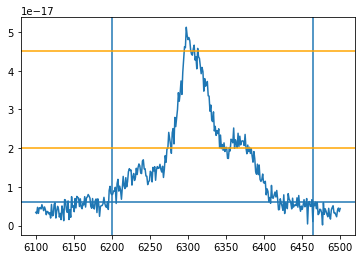

In [72]:
spec2 = sds['ZTF19abqwtfu_20200821_Keck1_v1']

region_size=100

idx = np.logical_and(spec2['restwave'] > 6100, spec2['restwave'] < 6500)
plt.plot(spec2['restwave'][idx], spec2['flux'][idx])
wave_start = 6300-region_size
wave_stop = 6364+region_size
plt.axvline(wave_start)
plt.axvline(wave_stop)
bkg = 0.6e-17
plt.axhline(bkg)

plt.axhline(0.45e-16, color='orange')
plt.axhline(0.2e-16, color='orange')

In [79]:
region_size = np.linspace(10, 120)
lums = np.empty_like(region_size)
#temp = np.empty_like(region_size)

fig, ax1 = plt.subplots(nrows=1, sharex=True, figsize=(11, 8))

for beta_ratio in [1.0, 1.3, 1.5, 1.8, 2.0]:
    for i in range(len(lums)):
        # estimate the 5577 line
        #lums_5577 = extract_5577(spec, region_size[i])
    
        # estimate the 63xx line
        lums_63xx = extract_63xx(spec2, region_size[i], bkg=0.6e-17)
    
        lums[i] = lums_63xx
        
        
    #print(beta_ratio, temp.max())
    ax1.plot(region_size, lums/1e38, label='beta=%.1f' % beta_ratio)
    #ax2.plot(region_size, mass, label='beta=%.1f' % beta_ratio)
ax1.grid()

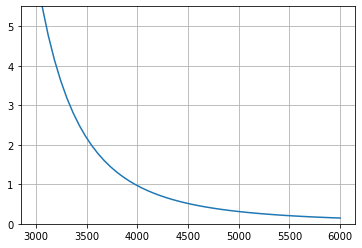

In [80]:
# estimate the mass
temp = np.linspace(3000, 6000)
mass = 16e38/0.5/9.7e41 * np.exp(22720/temp)
plt.plot(temp, mass)
plt.ylim((0, 5.5))
plt.grid()